In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c2 = np.max([model.optimizer.C2[1] - ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[0]])
    model.optimizer.c1 = np.min([model.optimizer.C1[0] + ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8827160493827161, Loss: 0.625151104397244
Checkpoint 20, Accuracy: 0.9074074074074074, Loss: 0.5331739143089012
Checkpoint 30, Accuracy: 0.9135802469135802, Loss: 0.5275887736567745
Checkpoint 40, Accuracy: 0.9074074074074074, Loss: 0.47313026145652487
Checkpoint 50, Accuracy: 0.9012345679012346, Loss: 0.4063328637017144
Checkpoint 60, Accuracy: 0.9074074074074074, Loss: 0.4367568051373517
Checkpoint 70, Accuracy: 0.9567901234567902, Loss: 0.28565940150508173
Checkpoint 80, Accuracy: 0.9691358024691358, Loss: 0.27183610421639903
Checkpoint 90, Accuracy: 0.9444444444444444, Loss: 0.2746857890376338
Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.23631102950484664
Checkpoint 110, Accuracy: 0.9629629629629629, Loss: 0.22586774826049805
Checkpoint 120, Accuracy: 0.9506172839506173, Loss: 0.22266613995587384
Checkpoint 130, Accuracy: 0.9567901234567902, Loss: 0.18879593743218315
Checkpoint 140, Accuracy: 0.9629629629629629, Loss: 0.1523354141800492
Checkpoin

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

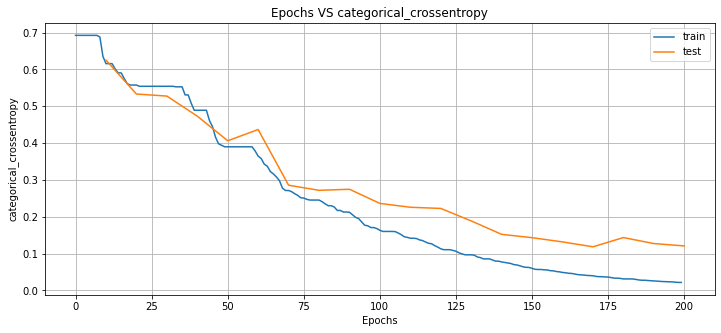

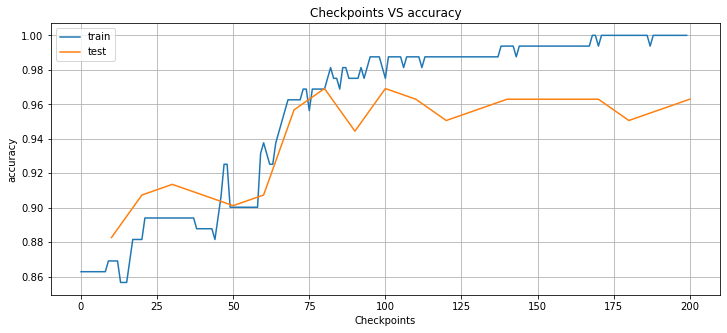

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.11414804 0.8792647  0.00658731]
[1. 0. 0.] <-> [0.99501944 0.00239678 0.00258375]
[1. 0. 0.] <-> [0.99632734 0.0015117  0.00216092]
[1. 0. 0.] <-> [0.22273214 0.00311935 0.77414846]
[0. 1. 0.] <-> [0.01795867 0.98066324 0.00137804]
[1. 0. 0.] <-> [0.9956535  0.00145367 0.00289281]
[1. 0. 0.] <-> [0.9914908  0.00165858 0.00685063]
[1. 0. 0.] <-> [0.988267   0.00195766 0.00977537]
[1. 0. 0.] <-> [0.9958579  0.00139599 0.00274618]
[0. 1. 0.] <-> [0.01571025 0.98300606 0.00128378]
[1. 0. 0.] <-> [0.9905978  0.00408313 0.00531907]
[1. 0. 0.] <-> [0.98538405 0.00211818 0.01249782]
[0. 1. 0.] <-> [0.03014205 0.9675876  0.00227034]
[1. 0. 0.] <-> [0.99293655 0.00154943 0.00551402]
[0. 1. 0.] <-> [0.01570362 0.9829952  0.00130117]
[0. 0. 1.] <-> [3.6197649e-03 1.6271281e-04 9.9621755e-01]
[1. 0. 0.] <-> [0.9953252  0.00145848 0.00321629]
[1. 0. 0.] <-> [0.9938844  0.00245103 0.00366461]
[0. 1. 0.] <-> [0.01570389 0.9830057  0.00129046]
[1. 0. 0.] <-> [0.99549073 0.00151653 0.0

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8827160493827161, 'mean_square_error': 0.30293712524352034, 'categorical_crossentropy': 0.625151104397244, 'essential_metrics': {0: {'tp_hit': 73, 'fp_hit': 14, 'tn_hit': 16, 'fn_hit': 5}, 1: {'tp_hit': 16, 'fp_hit': 5, 'tn_hit': 87, 'fn_hit': 0}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 10} 


{'accuracy': 0.9074074074074074, 'mean_square_error': 0.2717020758126878, 'categorical_crossentropy': 0.5331739143089012, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 8, 'tn_hit': 22, 'fn_hit': 7}, 1: {'tp_hit': 16, 'fp_hit': 7, 'tn_hit': 85, 'fn_hit': 0}, 2: {'tp_hit': 6, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 8}}, 'checkpoint': 20} 


{'accuracy': 0.9135802469135802, 'mean_square_error': 0.2631526206589976, 'categorical_crossentropy': 0.5275887736567745, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 8, 'tn_hit': 22, 'fn_hit': 6}, 1: {'tp_hit': 14, 'fp_hit': 5, 'tn_hit': 87, 'fn_hit': 2}, 2: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit'

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.7125262 -2.9075198 -3.         1.3327231  3.       ]
 bias: 3.0

Neuron 1: weights:
[-0.94061154  2.5055318   3.          0.06868587 -3.        ]
 bias: -2.888913631439209

Neuron 2: weights:
[-0.2405091  -3.          0.966295    0.21301495  2.3420672 ]
 bias: -2.7388455867767334

Neuron 3: weights:
[ 0.06833762  3.          0.49496958 -0.20577307 -3.        ]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[ 3.        -2.0664055 -3.         3.       ]
 bias: -0.6856666803359985

Neuron 1: weights:
[-3.         3.        -2.5815248 -0.4094529]
 bias: 1.7936843633651733

Neuron 2: weights:
[-1.06807   -2.2566338  3.        -3.       ]
 bias: 3.0

$

